# GBP/USD Exchange Rate during 2017 UK Election Night - Under Construction



In [49]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab

import tweepy

import json

import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [30]:
CONSUMER_KEY = '4BByuBKYk19fpSl5iMIkju3c0'
CONSUMER_SECRET = '2EK91aT0s7uMJ1oWECBRUwkXrxGykigrsmtqtOIAvFBPXiucQq'
ACCESS_TOKEN = '892729320736739328-E30nIY5dacqxeugxPoe3TXB2fIjITZB'
ACCESS_TOKEN_SECRET = 'WMViNA7y1d1trkb5nt7L5dOAHdScmYBMHm33sLeUVZrWT'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

tweets_raw = api.user_timeline(screen_name = 'bbcelection', count = 200, include_rts = False)
for i in range(0,5):
    oldest=tweets_raw[-1].id
    new_tweets = api.user_timeline(screen_name = 'bbcelection',count=200,max_id=oldest)
    tweets_raw.extend(new_tweets)

data = [[tw.created_at.year, tw.created_at.month, tw.created_at.day,"%s.%s"%(tw.created_at.hour, tw.created_at.minute), tw.id_str, tw.text.encode("utf8")] for tw in tweets_raw ]
tweets=pd.DataFrame(data, columns=['year','month','date','time','tweet_id','tweet'])
tweets = tweets[tweets.year==2017]


In [134]:
# Wikipedia data
UKpoll = pd.read_csv('data/UK2017Poll.txt', sep='\t', header=0)
UKpoll.columns=['ID','Con_poll', 'Lab_poll', 'Lib_poll','SNP_poll','Pla_poll','Greens_poll',\
                'UKIP_poll', 'Other_poll', 'Seat','Region','2015']
results = pd.read_csv("data/result.csv")
results

,ID,Constituency,Cnty,Rgn,Last Election,Party,Votes,Share,Majrty,turnout,...,UKIP,Grn[d],DUP,SF,PC,SDLP,UUP,APNI,Other[e],Total
0,W07000049,Aberavon,WGM,WLS,Lab,Lab,"22,662",68.10%,"16,761",66.70%,...,1345.0,NaN,NaN,NaN,2761.0,NaN,NaN,NaN,NaN,33268
1,W07000058,Aberconwy,CON,WLS,Con,Con,"14,337",44.60%,635,71.00%,...,NaN,NaN,NaN,NaN,3170.0,NaN,NaN,NaN,NaN,32150
2,S14000001,Aberdeen North,SCT,SCT,SNP,SNP,"15,170",41.30%,"4,139",59.20%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,522.0,36757
3,S14000002,Aberdeen South,SCT,SCT,SNP,Con,"18,746",42.10%,"4,752",68.50%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44493
4,S14000003,Airdrie and Shotts,SCT,SCT,SNP,SNP,"14,291",37.60%,195,59.20%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38002
5,E14000530,Aldershot,HAM,SE,Con,Con,"26,950",55.10%,"11,473",64.20%,...,1796.0,1090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48950
6,E14000531,Aldridge-Brownhills,WMD,WM,Con,Con,"26,317",65.40%,"14,307",66.70%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,565.0,40235
7,E14000532,Altrincham and Sale West,GTM,NW,Con,Con,"26,933",51.00%,"6,426",72.10%,...,NaN,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,299.0,52790
8,W07000043,Alyn and Deeside,CON,WLS,Lab,Lab,"23,315",52.10%,"5,235",71.00%,...,1117.0,NaN,NaN,NaN,1171.0,NaN,NaN,NaN,NaN,44760
9,E14000533,Amber Valley,DBY,EM,Con,Con,"25,905",56.50%,"8,300",67.30%,...,NaN,650.0,NaN,NaN,NaN,NaN,NaN,NaN,551.0,45811


In [56]:
tweets.tweet=tweets.tweet.astype(str)
tweets_cleaned = tweets[tweets.tweet.str.contains('#GE2017')]
tweets_cleaned['time_full'] = tweets_cleaned["year"].map(str)+ "/"+ tweets_cleaned["month"].map(str) + \
    "/"+ tweets_cleaned["date"].map(str)  + "/"+ tweets_cleaned["time"].map(str) 

## Merging result data with time

In [66]:
tweets_cleaned['Constituency']=np.nan
for i in range(len(tweets)):
    tweets_cleaned.Constituency[i] = tweets_cleaned.tweet[i][tweets_cleaned.tweet[i].find("\'")+1:tweets_cleaned.tweet[i].find(":")]
tweets_cleaned.to_csv('data/tweets.csv',sep=',')



C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [75]:
#manual matching
tw_matched = pd.read_csv('data/tweets_matched.csv')
tw_matched = tw_matched.dropna(axis=0, how='any')
tw_matched = tw_matched.drop_duplicates(subset='ID', keep='last')
tw_matched.index = np.arange(len(tw_matched))
tw_matched

,year,month,date,time,tweet_id,tweet,time_full,Constituency,ID
0,2017,6,9,20.23,8.730000e+17,b'Kensington: LAB win #GE2017. Full results: h...,2017/6/9/20.23,Kensington,E14000768
1,2017,6,9,8.27,8.730000e+17,b'South East Cornwall: CON hold #GE2017. Full ...,2017/6/9/8.27,South East Cornwall,E14000938
2,2017,6,9,8.60,8.730000e+17,b'St Austell: CON hold #GE2017. Full results: ...,2017/6/9/8.6,St Austell,E14000961
3,2017,6,9,6.40,8.730000e+17,b'St Ives: CON hold #GE2017. Full results: htt...,2017/6/9/6.40,St Ives,E14000964
4,2017,6,9,6.13,8.730000e+17,b'Dudley North: LAB hold #GE2017. Full results...,2017/6/9/6.13,Dudley North,E14000671
5,2017,6,9,6.10,8.730000e+17,b'Newcastle-under-Lyme: LAB hold #GE2017. Full...,2017/6/9/6.10,Newcastle-under-Lyme,E14000834
6,2017,6,9,6.90,8.730000e+17,b'Crawley: CON hold #GE2017. Full results: htt...,2017/6/9/6.9,Crawley,E14000652
7,2017,6,9,6.90,8.730000e+17,b'Ashfield: LAB hold #GE2017. Full results: ht...,2017/6/9/6.9,Ashfield,E14000535
8,2017,6,9,6.80,8.730000e+17,b'Richmond Park: CON win #GE2017. Full results...,2017/6/9/6.8,Richmond Park,E14000896
9,2017,6,9,5.53,8.730000e+17,b'Ealing Southall: LAB hold #GE2017. Full resu...,2017/6/9/5.53,Ealing Southall,E14000676


In [135]:
results = results.merge( tw_matched[['ID','time_full']], how='left', left_on = 'ID', right_on='ID')
results
results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']]=(results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']].T/results['Total']).T
results['time']=np.nan
for i in range(0,len(results)):
    try:
        results['time'].loc[i]= datetime.strptime(results.time_full[i],'%Y/%m/%d/%H.%M')
    except:
        results['time'].loc[i] = np.nan

C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Merging poll with result

In [136]:
full_table = pd.merge(results, UKpoll,  how='left', left_on='ID', right_on = 'ID')
full_table = full_table.sort_values(by='time').reset_index(drop=True)


## Other factors
taken from UK sensus 

In [137]:
xl = pd.ExcelFile("data/Wages.xlsx")
wages=xl.parse("Data")
wages.head()
full_table = pd.merge(full_table, wages[['ONSConstID','WageMedianConst']],  how='left', left_on='ID', right_on = 'ONSConstID')

xl = pd.ExcelFile("data/Business-numbers.xlsx")
business=xl.parse("Data")
#full_table = pd.merge(full_table, business,  how='left', left_on='Constituency', right_on = 'ConstituencyName')

xl = pd.ExcelFile("data/Population-by-age.xlsx")
population=xl.parse("Data")
full_table = pd.merge(full_table, population[['ONSConstID','Pop65ConstRate']],  how='left', left_on='ID', right_on = 'ONSConstID')

full_table['islab'] = (full_table['Last Election']=='Lab').astype(int)
full_table['iscon'] = (full_table['Last Election']=='Con').astype(int)
full_table['islib'] = (full_table['Last Election']=='LD').astype(int)
full_table['issnp'] = (full_table['Last Election']=='SNP').astype(int)


Index(['ID', 'Constituency', 'Cnty', 'Rgn', 'Last Election', 'Party', 'Votes',
       'Share', 'Majrty', 'turnout', 'Con[b]', 'Lab[c]', 'LD', 'SNP', 'UKIP',
       'Grn[d]', 'DUP', 'SF', 'PC', 'SDLP', 'UUP', 'APNI', 'Other[e]', 'Total',
       'time_full', 'time', 'Con_poll', 'Lab_poll', 'Lib_poll', 'SNP_poll',
       'Pla_poll', 'Greens_poll', 'UKIP_poll', 'Other_poll', 'Seat', 'Region',
       '2015', 'ONSConstID_x', 'WageMedianConst', 'ONSConstID_y',
       'Pop65ConstRate', 'islab', 'iscon', 'islib', 'issnp'],
      dtype='object')

In [142]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(full_table)

            ID                                 Constituency Cnty  Rgn  \
0    E14000831                  Newcastle upon Tyne Central  TWR   NE   
1    E14000982                           Sunderland Central  TWR   NE   
2    E14000832                     Newcastle upon Tyne East  TWR   NE   
3    E14000851                                North Swindon  WIL   SW   
4    E14001020               Washington and Sunderland West  TWR   NE   
5    E14000833                    Newcastle upon Tyne North  TWR   NE   
6    E14000769                                    Kettering  NTH   EM   
7    E14000868                                     Nuneaton  WAR   WM   
8    E14000819                                Middlesbrough  CLV   NE   
9    E14000606                                   Broxbourne  HRT    E   
10   E14000544                      Basildon and Billericay  ESS    E   
11   E14001053                                   Workington  CMA   NW   
12   E14000944                                South

## Analysis

In [193]:
columns = ['time', 'Constituency','low', 'ave', 'high']
index= full_table.index
pred=pd.DataFrame(index=index, columns=columns)

sim_num = 50
for i in range(10,len(full_table)-14):
    
    #labour regression
   # data_lab=full_table[['Lab_poll','Lab[c]','Total','Last Election','WageMedianConst','Pop65ConstRate']]
    data_lab= pd.concat([full_table['Lab_poll'], full_table['WageMedianConst'],\
                      full_table['Pop65ConstRate'],full_table['islab']*full_table['WageMedianConst'],\
                     full_table['islab']*full_table['Pop65ConstRate'],full_table['Lab[c]']], axis=1)
    X_lab = data_lab.drop('Lab[c]',axis=1)[0:i]
    Y_lab=data_lab['Lab[c]'][0:i]
    X_lab=sm.add_constant(X_lab, has_constant='add')
    model_lab = sm.RLM(Y_lab, X_lab,missing = 'drop').fit()
    
    
    #Conservatives regression
    #data_con=full_table[['Con_poll','Con[b]','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_con=pd.concat([full_table['Con_poll'], full_table['WageMedianConst'],
                     full_table['Pop65ConstRate'],  full_table['iscon']*full_table['WageMedianConst'],
                      full_table['iscon']*full_table['Pop65ConstRate'],full_table['Con[b]']], axis=1)
    X_con = data_con.drop(['Con[b]'], axis = 1)[0:i]
    Y_con=data_con['Con[b]'][0:i]
    X_con=sm.add_constant(X_con, has_constant='add')
    model_con = sm.RLM(Y_con, X_con,missing = 'drop').fit()
    
    
    #Liberal Regression
    #data_lib=full_table[['Lib_poll','LD','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_lib=pd.concat([full_table['Lib_poll'], full_table['WageMedianConst'],
                     full_table['Pop65ConstRate'],full_table['islib']* full_table['WageMedianConst'],
                    full_table['islib']*full_table['Pop65ConstRate'],full_table['LD']], axis=1)
    X_lib = data_lib.drop(['LD'],axis=1)[0:i]
    Y_lib=data_lib['LD'][0:i]
    X_lib=sm.add_constant(X_lib, has_constant='add')
    model_lib = sm.RLM(Y_lib, X_lib,missing = 'drop').fit()
    

    #SNP Regression
    #SNP has no votes and poll in many regions, assign 0 to model in this case
    full_table['SNP']=full_table['SNP'].fillna(0)
    #data_snp=full_table[['SNP_poll','SNP','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_snp=pd.concat([full_table['SNP_poll'], full_table['WageMedianConst'],
                     full_table['Pop65ConstRate'],full_table['issnp']*full_table['WageMedianConst'],
                    full_table['issnp']*full_table['Pop65ConstRate'], full_table['SNP']], axis=1)
    X_snp = data_snp.drop(['SNP'],axis = 1)[0:i]
    Y_snp=data_snp['SNP'][0:i]
    X_snp=sm.add_constant(X_snp, has_constant='add')
    try:
        model_snp = sm.RLM(Y_snp, X_snp,missing = 'drop').fit()
    except:
        model_snp = 0
        

    

    
    result = np.zeros([sim_num, len(full_table)-i])
    
    #Sampling the regression parameters to generate predicted outcome
    for j in range(0, sim_num):
        
        #Labour
        param_lab = np.random.multivariate_normal(np.asarray(model_lab.params), RegressionResults.cov_params(model_lab), sim_num)
        predict_lab=sm.add_constant(data_lab.drop('Lab[c]',axis=1)[i:], has_constant='add')
        
        
        #fill NaN with mean
        predict_lab = predict_lab.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_lab,np.array(predict_lab).T)
        result_lab = np.random.normal(result_temp,np.std(model_lab.resid))
        
        
        
        #Conservative
        param_con = np.random.multivariate_normal(np.asarray(model_con.params), RegressionResults.cov_params(model_con), sim_num)
        predict_con=sm.add_constant(data_con.drop(['Con[b]'], axis = 1)[i:], has_constant='add')
        
        
        predict_con = predict_con.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_con,np.array(predict_con).T)
        result_con = np.random.normal(result_temp,np.std(model_con.resid))
        
        
        
        #Liberal
        param_lib = np.random.multivariate_normal(np.asarray(model_lib.params), RegressionResults.cov_params(model_lib), sim_num)
        predict_lib=sm.add_constant(data_lib.drop(['LD'],axis=1)[i:], has_constant='add')
        
        
        predict_lib = predict_lib.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_lib,np.array(predict_lib).T)
        result_lib = np.random.normal(result_temp,np.std(model_lib.resid))

        
        #SNP
        if not model_snp==0 and not np.isnan(model_snp.bse[0]):
            param_snp = np.random.multivariate_normal(np.asarray(model_snp.params), RegressionResults.cov_params(model_snp), sim_num)
            predict_snp=sm.add_constant(data_snp.drop(['SNP'],axis = 1)[i:], has_constant='add')
           
            
            predict_snp = predict_lib.fillna(predict_snp.mean())
            
            result_temp =  np.matmul(param_snp,np.array(predict_snp).T)
            result_snp = np.random.normal(result_temp,np.std(model_snp.resid))
            
        else:
            #no data
            result_snp = np.nan_to_num(np.tile(data_snp['SNP_poll'][i:],(sim_num,1)))/100
        
        result_pla = np.nan_to_num(np.tile(full_table['Pla_poll'][i:],(sim_num,1)))/100
        result_ukip = np.nan_to_num(np.tile(full_table['UKIP_poll'][i:],(sim_num,1)))/100
        
        result_temp = (result_con>result_lab) & (result_con>result_lib) & (result_con>result_snp)\
                        & (result_con>result_pla) & (result_con>result_ukip) 
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=len(full_table.Party[0:i][full_table.Party=='Con'])+ np.count_nonzero(result, axis=1)
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot
    pred.time[i]=full_table.time[i]
    pred.Constituency[i]=full_table.ID[i]
    pred.low[i]=np.mean(EEV)-np.std(EEV)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.mean(EEV)+np.std(EEV)

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:171: RuntimeWarning: invalid value encountered in true_divide
  tmp_results.scale).sum()
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:284: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in greater
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: covariance is not positive-semidefinite.
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: covariance is not positive-semidefinite.


In [181]:
fx = pd.read_csv('data/FX data.csv',header=None,sep='\;')

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[5], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:4].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]
fx['time'] = [datetime.strptime(v, '%Y%m%d %H%M%S') for v in fx['time']]

#change time to UTC to match twitter
fx['time'] = [v + timedelta(hours=5) for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:5],1)


C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


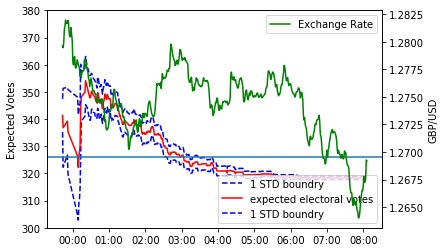

In [208]:
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='1 STD boundry')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes')
ax1.plot_date(pred.time, pred.high,'b--', label='1 STD boundry')
plt.ylabel('Expected Votes')
pylab.legend(loc='lower right')
plt.axhline(y=326)
ax1.set_ylim([300,380])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('GBP/USD')
plt.xlabel('UTC Time')
pylab.legend(loc='upper right')


plt.show()


In [145]:

i=10
data_lab= pd.concat([full_table['Lab_poll'], full_table['WageMedianConst'],\
                      full_table['Pop65ConstRate'],full_table['islab']*full_table['WageMedianConst'],\
                     full_table['islab']*full_table['Pop65ConstRate'],full_table['Lab[c]']], axis=1)
X_lab = data_lab.drop('Lab[c]',axis=1)[0:i]
Y_lab=data_lab['Lab[c]'][0:i]
X_lab=sm.add_constant(X_lab, has_constant='add')
model_lab = sm.RLM(Y_lab, X_lab,missing = 'drop').fit()

In [210]:
full_table[0:100].T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ID,E14000831,E14000982,E14000832,E14000851,E14001020,E14000833,E14000769,E14000868,E14000819,E14000606,...,E14000542,E14000611,S14000027,E14000744,E14000693,E14000747,E14000858,E14000706,E14000845,S14000036
Constituency,Newcastle upon Tyne Central,Sunderland Central,Newcastle upon Tyne East,North Swindon,Washington and Sunderland West,Newcastle upon Tyne North,Kettering,Nuneaton,Middlesbrough,Broxbourne,...,Barnsley East,Bury North,Na h-Eileanan an Iar,Hertford and Stortford,Epping Forest,Heywood and Middleton,North West Leicestershire,Fylde,North East Hertfordshire,Glenrothes
Cnty,TWR,TWR,TWR,WIL,TWR,TWR,NTH,WAR,CLV,HRT,...,SYK,GTM,SCT,HRT,ESS,GTM,LEI,LAN,HRT,SCT
Rgn,NE,NE,NE,SW,NE,NE,EM,WM,NE,E,...,YTH,NW,SCT,E,E,NW,EM,NW,E,SCT
Last Election,Lab,Lab,Lab,Con,Lab,Lab,Con,Con,Lab,Con,...,Lab,Con,SNP,Con,Con,Lab,Con,Con,Con,SNP
Party,Lab,Lab,Lab,Con,Lab,Lab,Con,Con,Lab,Con,...,Lab,Lab,SNP,Con,Con,Lab,Con,Con,Con,SNP
Votes,"24,071","25,056","28,127","29,431","24,639","26,729","28,616","23,755","23,404","29,515",...,"24,280","25,683","6,013","36,184","31,462","26,578","31,153","27,334","32,587","17,291"
Share,64.90%,55.50%,67.60%,53.60%,60.70%,55.40%,57.90%,51.60%,65.70%,62.20%,...,59.50%,53.60%,40.60%,60.30%,62.00%,53.30%,58.20%,58.80%,58.60%,42.80%
Majrty,"14,937","9,997","19,261","8,335","12,940","10,349","10,562","4,739","13,873","15,792",...,"13,283","4,375","1,007","19,035","18,243","7,617","13,286","11,805","16,835","3,267"
turnout,67.00%,62.00%,67.20%,68.50%,60.30%,73.10%,69.20%,66.60%,58.40%,64.60%,...,58.90%,70.90%,69.60%,72.90%,67.90%,62.40%,71.00%,70.50%,73.20%,60.90%


In [213]:
Y_con

0     0.246239
1     0.333821
2     0.212936
3     0.535976
4     0.288337
5     0.339215
6     0.579224
7     0.515662
8     0.267447
9     0.621565
10    0.609577
11    0.417315
12    0.259247
13    0.432894
14    0.250029
15    0.236577
16    0.436595
17    0.483880
18    0.195412
19    0.024014
20    0.554759
21    0.364817
22    0.568994
23    0.358258
24    0.284969
25    0.330680
26    0.313276
27    0.184229
28    0.216285
29    0.013084
        ...   
70    0.629933
71    0.402515
72    0.163571
73    0.147696
74    0.415489
75    0.232292
76    0.253299
77    0.474720
78    0.218130
79    0.252149
80    0.251425
81    0.238419
82    0.549616
83    0.347476
84    0.008043
85    0.616681
86    0.414354
87    0.530367
88    0.261815
89    0.542933
90    0.269693
91    0.444816
92    0.164732
93    0.603147
94    0.619587
95    0.380247
96    0.581853
97    0.588245
98    0.586308
99    0.194955
Name: Con[b], Length: 100, dtype: float64